<a href="https://colab.research.google.com/github/proteus21/DATA-SCIENCE-STUDY/blob/main/COMPUTER-VISION-PROJECT/Detection_car_number_plates__V34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Detection car number plates

###Source Datasets

https://www.kaggle.com/datasets/andrewmvd/car-plate-detection

This dataset contains 433 images with bounding box annotations of the car license plates within the image.
Annotations are provided in the PASCAL VOC format.

In my analyse are modified and named as training and test folder. Annotations and images are join to one folder from 1 to 410 as training folder. The rest from 410 to the end is testing and production


### Contest:
1. [Installation of the google drive](#0)
2. [Downloading datasets from Kaggle to google drive](#1)
3. [Import of libraries](#2)
4. [Load libraries](#3)
5. [Understanding data sets and problems](#4)
6. [Preparation of data sets](#5)
7. [Create dataset](#6)
8. [Check the sample data](#8)
9. [Generation of X set ](#9)
10. [Preprocesing - Normalization](#10)
11. [Simple CNN](#11)
12. [Evolution of the data and prediction](#12)
13. [Testing the model prediction](#13)
14. [Model1- VGG16a](#14)
15. [Evolution of the data and prediction](#15)
16. [Testing the model prediction](#16)

### <a name='0'></a> Installation of the google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
# mounting google drive

Mounted at /content/drive


### <a name='1'></a> Downloading datasets from Kaggle to google drive

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"


In [ ]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [ ]:

import os

os.environ['KAGGLE_USERNAME'] = "xxxxxx" # username from the json file
os.environ['KAGGLE_KEY'] = "yyyyyyyyyyyy" # key from the json file

!kaggle datasets download -d andrewmvd/car-plate-detection

 94% 191M/203M [00:02<00:00, 108MB/s] 
100% 203M/203M [00:02<00:00, 88.7MB/s]


In [ ]:
 !unzip -uq "/content/drive/My Drive/Kaggle/car-plate-detection.zip" -d "/content/drive/My Drive/Kaggle/" # unzip file in google drive

### <a name='2'></a> Import  of libraries

In [ ]:
!pip uninstall opencv-python

Found existing installation: opencv-python 4.7.0.72
Uninstalling opencv-python-4.7.0.72:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/cv2/*
    /usr/local/lib/python3.9/dist-packages/opencv_python-4.7.0.72.dist-info/*
    /usr/local/lib/python3.9/dist-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.9/dist-packages/opencv_python.libs/libQt5Gui-48e93776.so.5.15.0
    /usr/local/lib/python3.9/dist-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.9/dist-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.9/dist-packages/opencv_python.libs/libQt5XcbQpa-c112ba75.so.5.15.0
    /usr/local/lib/python3.9/dist-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.9/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.9/dist-packages/opencv_python.libs/libavcodec-16a334ab.so.59.37.100
    /usr/local/lib/python3.9/di

In [ ]:
!pip install opencv-python==4.6.0.66

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 12.8 MB/s eta 0:00:00


### <a name='3'></a>  Load libraries

In [53]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import cv2
import imutils
from glob import glob # listnening names as pattern
from sklearn.model_selection import train_test_split 
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow                                                      
import xml.etree.ElementTree as xet
import plotly.express as px

print(f"Tensorflow {tf.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Numpy {np.__version__}")
print(f"OpenCV-{cv2.__version__}")


print(os.path.abspath('..'))


Tensorflow 2.12.0
Pandas 1.4.4
Numpy 1.22.4
OpenCV-4.7.0
/


### <a name='4'></a>  Understanding data sets and problems

###Image processing

In [54]:
IMAGE_SIZE=224

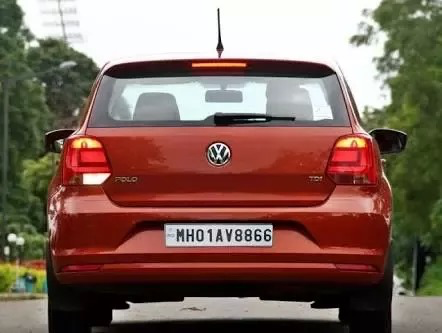

In [55]:
path = "/content/drive/My Drive/Kaggle/train/Cars108.png"
image = cv2.imread(path,1)
cv2_imshow(image)

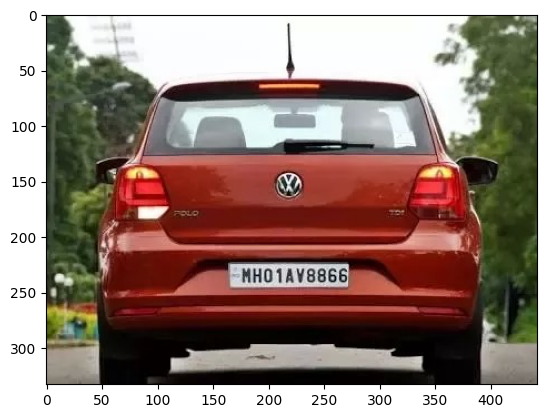

In [56]:
filename = "/content/drive/My Drive/Kaggle/train/Cars108.png"
car_img = cv2.imread(filename,1)
car_img=cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
plt.imshow(car_img)

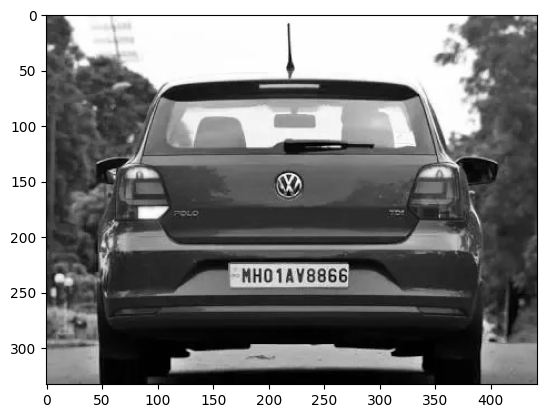

In [57]:
gray = cv2.cvtColor(car_img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)

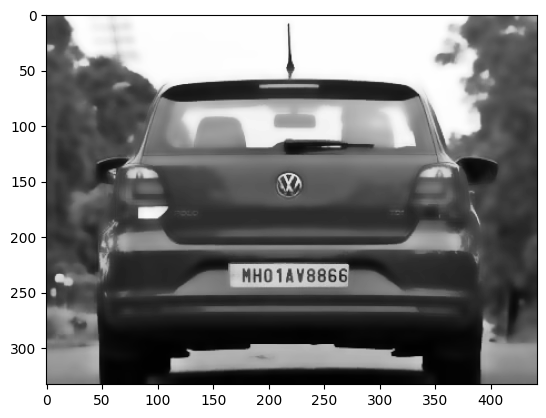

In [58]:
blurred_gray = cv2.bilateralFilter(gray, 10, 50, 50)
plt.imshow(blurred_gray, cmap='gray', vmin=0, vmax=255)

(333, 442)


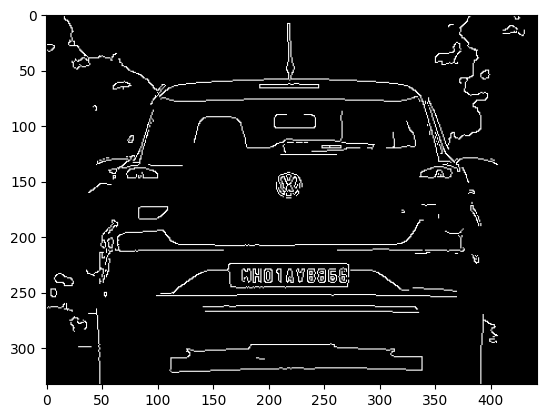

In [59]:
edged = cv2.Canny(blurred_gray, 140, 200) 
print(edged.shape)
plt.imshow(edged, cmap='gray', vmin=0, vmax=255)

### <a name='5'></a> Preparation of data sets

###  Project contains two types of the files such as  XML and png.
XML file has got etree with object --> bndbox and parameters xmin, xmax, ymin, ymax

In [60]:
x="Cars0.xml"
x[4:-4]

'0'

#### Labelling. Generation of set y 

In [61]:
# Read parametrs from xml file as y by built dataframe

labels_dict = dict(filepath=[],width=[], height=[],xmin_org=[],xmax_org=[],ymin_org=[],ymax_org=[],xmin=[],xmax=[],ymin=[],ymax=[])
dir_name = '/content/drive/My Drive/Kaggle/train/'
# Or we generete array y

y=[]

# Get list of all files in a given directory sorted by name
# If we have sorted file acc. to  number
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

list_of_files=  sorted(glob(dir_name + '*.xml'),key=sortKeyFunc)

for filename in list_of_files:
    #print(filename)
    tree = xet.parse(filename)
    root = tree.getroot()

    member_object = root.find('object')
    member_size = root.find('size')
    #labels_size = member_size.find('size')
    width = int( member_size.find('width').text)
    height = int( member_size.find('height').text)

    labels_info = member_object.find('bndbox')
    xmin_org = int(labels_info.find('xmin').text) 
    xmax_org = int(labels_info.find('xmax').text) 
    ymin_org = int(labels_info.find('ymin').text)
    ymax_org = int(labels_info.find('ymax').text)

    xmin = int(int(labels_info.find('xmin').text) /(width/IMAGE_SIZE))
    xmax = int(int(labels_info.find('xmax').text) /(width/IMAGE_SIZE))
    ymin = int(int(labels_info.find('ymin').text) /(height/IMAGE_SIZE))
    ymax = int(int(labels_info.find('ymax').text)/ (height/IMAGE_SIZE))


    labels_dict['filepath'].append(filename)
    labels_dict['width'].append(width)
    labels_dict['height'].append(height)
    labels_dict['xmin_org'].append(xmin_org)
    labels_dict['xmax_org'].append(xmax_org)
    labels_dict['ymin_org'].append(ymin_org)
    labels_dict['ymax_org'].append(ymax_org)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # create directly as array
    y.append([xmin,ymin,xmax,ymax])



In [62]:
print(y[0][0],y[0][1],y[0][2],y[0][3]) # scaled image by IMAGE_SIZE


101 104 187 144


### <a name='6'></a>Create dataset

In [63]:
# We bulit data frame for parametrs
df=pd.DataFrame(labels_dict)
df.to_csv('labels.csv', index=False)
df.head()

filepath  width  height  xmin_org  \
0  /content/drive/My Drive/Kaggle/train/Cars0.xml    500     268       226   
1  /content/drive/My Drive/Kaggle/train/Cars1.xml    400     248       134   
2  /content/drive/My Drive/Kaggle/train/Cars2.xml    400     400       229   
3  /content/drive/My Drive/Kaggle/train/Cars3.xml    400     225       142   
4  /content/drive/My Drive/Kaggle/train/Cars4.xml    590     350       156   

   xmax_org  ymin_org  ymax_org  xmin  xmax  ymin  ymax  
0       419       125       173   101   187   104   144  
1       262       128       160    75   146   115   144  
2       270       176       193   128   151    98   108  
3       261       128       157    79   146   127   156  
4       503        82       253    59   190    52   161

In [64]:
print(df.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  411 non-null    object
 1   width     411 non-null    int64 
 2   height    411 non-null    int64 
 3   xmin_org  411 non-null    int64 
 4   xmax_org  411 non-null    int64 
 5   ymin_org  411 non-null    int64 
 6   ymax_org  411 non-null    int64 
 7   xmin      411 non-null    int64 
 8   xmax      411 non-null    int64 
 9   ymin      411 non-null    int64 
 10  ymax      411 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 35.4+ KB
None


### <a name='8'></a> Check the sample data

In [123]:
df.iloc[108]  

filepath    /content/drive/My Drive/Kaggle/train/Cars108.xml
width                                                    442
height                                                   333
xmin_org                                                 158
xmax_org                                                 277
ymin_org                                                 216
ymax_org                                                 248
xmin                                                      80
xmax                                                     140
ymin                                                     145
ymax                                                     166
Name: 108, dtype: object


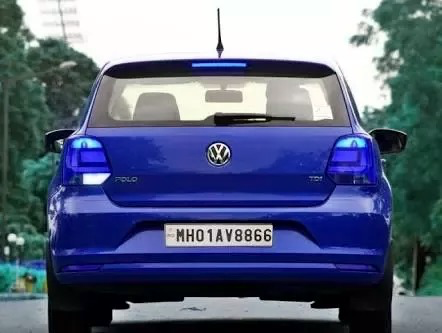

In [67]:
# In order to build 
filename = "/content/drive/My Drive/Kaggle/train/Cars108.png"
car_img = cv2.imread(filename,1)
fig = px.imshow(car_img)
fig.update_layout(width=400, height=400, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure -Cars 368.png with bounding box')
fig.add_shape(type='rect',x0=labels_dict['xmin_org'][108], x1=labels_dict['xmax_org'][108], y0=labels_dict['ymin_org'][108], y1=labels_dict['ymax_org'][108], xref='x', yref='y',line_color='cyan')


### <a name='9'></a>Generation of set X 

In [68]:
#IMAGE_SIZE=224
image_dir="/content/drive/My Drive/Kaggle/train"
path=os.path.join(image_dir, '*g')
#files=glob(path)
files=sorted(glob(path),key=sortKeyFunc)

X=[]
X1=[]
for f in files:
  img=cv2.imread(f)
  img=cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE))
  X.append(np.array(img))




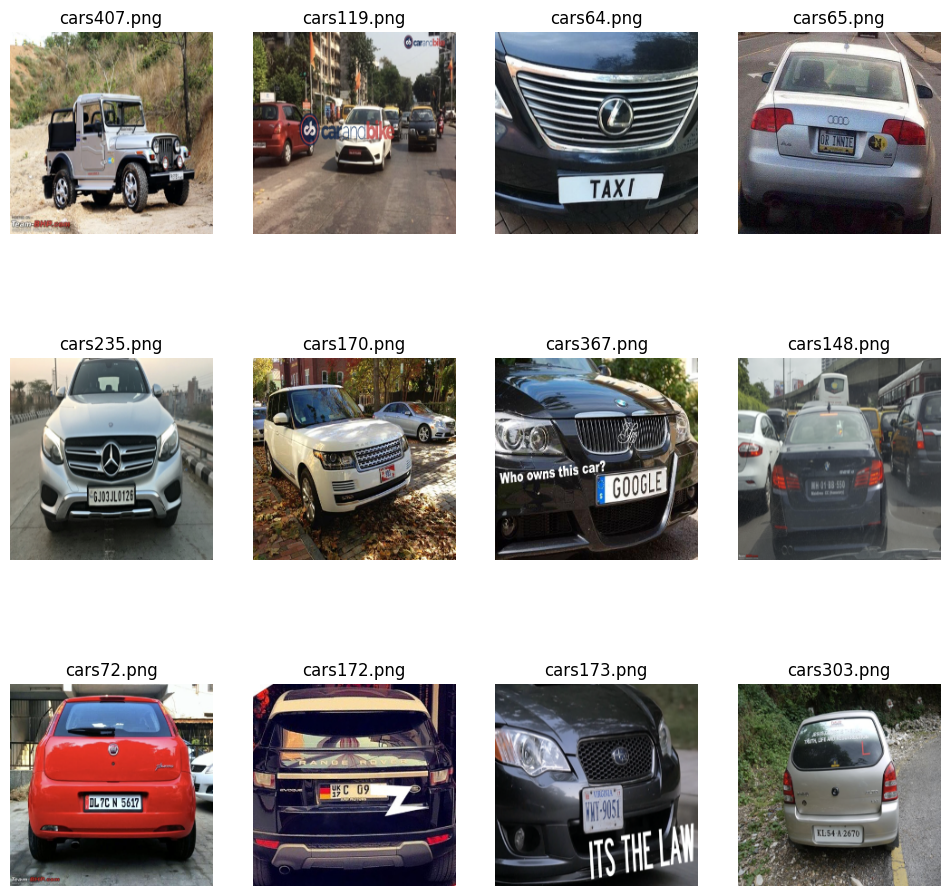

In [69]:
dataset_index=[]
for i in range (12):
  dataset_index.append(np.random.randint(0, len(X)))

plt.figure(figsize=(12, 12))
for index, i  in enumerate(dataset_index):
  plt.subplot(3,4,index+1)
  plt.axis('off')
  plt.title(f'cars{i}.png')
  plt.imshow(cv2.cvtColor(X[i],cv2.COLOR_BGR2RGB))



In [70]:
print(f' X.Shape{np.array(X).shape}')
print(f' y.Shape{np.array(y).shape}')

 X.Shape(411, 224, 224, 3)
 y.Shape(411, 4)


cars407.png 174 153 193 169
cars119.png 104 126 121 138
cars64.png 67 156 182 184
cars65.png 89 105 129 137
cars235.png 79 134 141 171
cars170.png 142 116 155 137
cars367.png 109 113 206 163
cars148.png 75 133 122 157
cars72.png 87 122 142 140
cars172.png 84 110 147 126
cars173.png 95 116 141 161
cars303.png 84 157 138 176


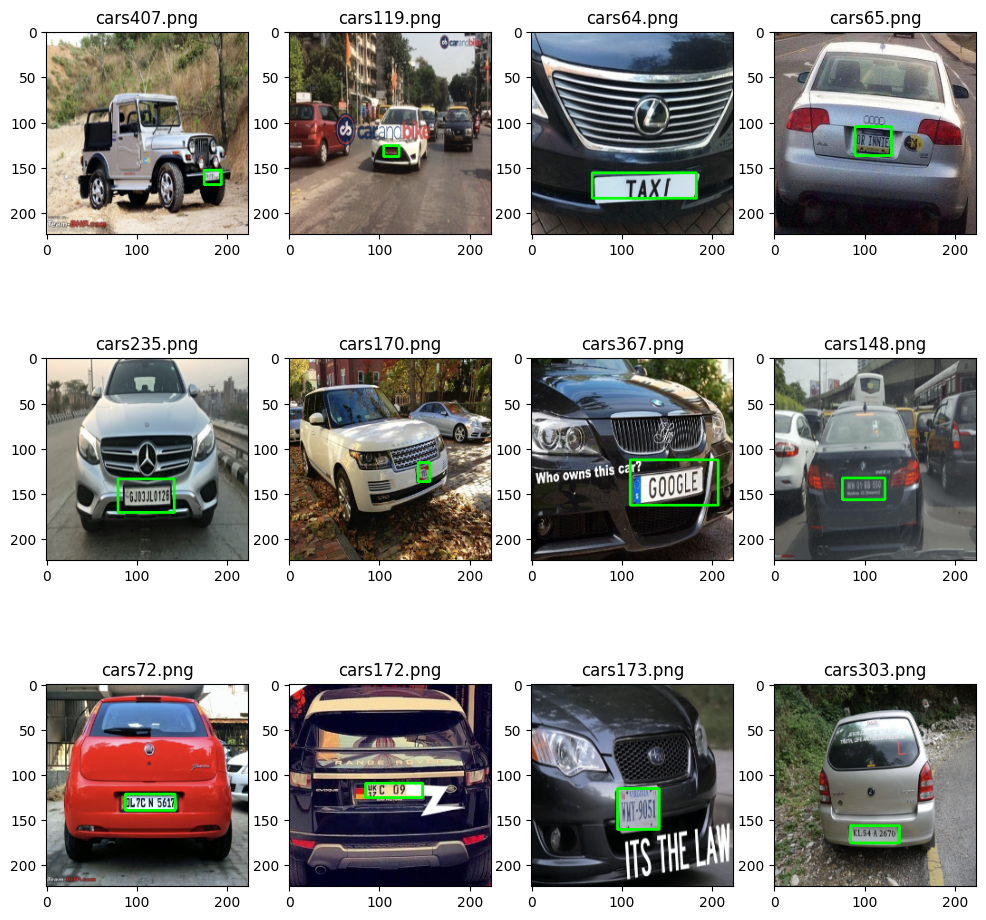

In [71]:
plt.figure(figsize=(12, 12))
for index, i  in enumerate(dataset_index):
  plt.subplot(3,4,index+1)
  #plt.axis('off')
  image = cv2.rectangle(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB),(int(y[i][0]),int(y[i][1])),(int(y[i][2]),int(y[i][3])),(0, 255, 0), 2)
  plt.title(f'cars{i}.png')
  plt.imshow(image)
  print(f'cars{i}.png',int(y[i][0]),int(y[i][1]),int(y[i][2]),int(y[i][3]))


In [72]:
print(labels_dict['xmin'][95],labels_dict['xmax'][95],labels_dict['ymin'][95], labels_dict['ymax'][95])

103 151 101 147


### <a name='10'></a> Preprocesing - Normalization

In [73]:
X=np.array(X,dtype=np.float32) # Divide by max imaga scale color
X=X/225
y=np.array(y,dtype=np.float32)  # Divide by image size
y=y/224



In [74]:
from tensorflow.python import train
X_train,X_test,y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [75]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((295, 224, 224, 3), (83, 224, 224, 3), (295, 4), (83, 4))

### <a name='11'></a>  Simple CNN


In [78]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [79]:
# Model definition
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='linear')
])

# Model compilation
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Definition of the augmentation data generator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    # cross validation 
    validation_split=0.2
)

# Model training with data augmentation
for i in range(10):
    print("Epoch", i+1)
    j = 0
    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=32):
        loss, mae = model.train_on_batch(X_batch, y_batch)
        j += 1
        if j >= len(X_train) / 32:
            break

# Save model
model.save("model.h5")

history=model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 1/100
10/10 [==============================] - 1s 71ms/step - loss: 0.0308 - mae: 0.1350 - val_loss: 0.0239 - val_mae: 0.1221
Epoch 2/100
10/10 [==============================] - 1s 51ms/step - loss: 0.0272 - mae: 0.1264 - val_loss: 0.0236 - val_mae: 0.1222
Epoch 3/100
10/10 [==============================] - 1s 52ms/step - loss: 0.0260 - mae: 0.1222 - val_loss: 0.0218 - val_mae: 0.1192
Epoch 4/100
10/10 [==============================] - 1s 52ms/step - loss: 0.0235 - mae: 0.1151 - val_loss: 0.0180 - val_mae: 0.1078
Epoch 5/100
10/10 [==============================] - 0s 48ms/step - loss: 0.0212 - mae: 0.1101 - val_loss: 0.0165 - val_mae: 0.1017
Epoch 6/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0178 - mae: 0.1011 - val_loss: 0.0161 - val_mae: 0.1003
Epoch 7/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0162 - mae: 0.0957 - val_loss: 0.0139 - val_mae: 0.

### <a name='12'></a>Evolution of data and predictions

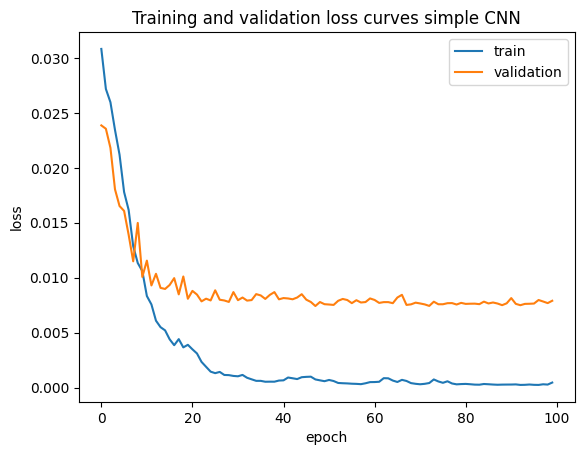

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss curves simple CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

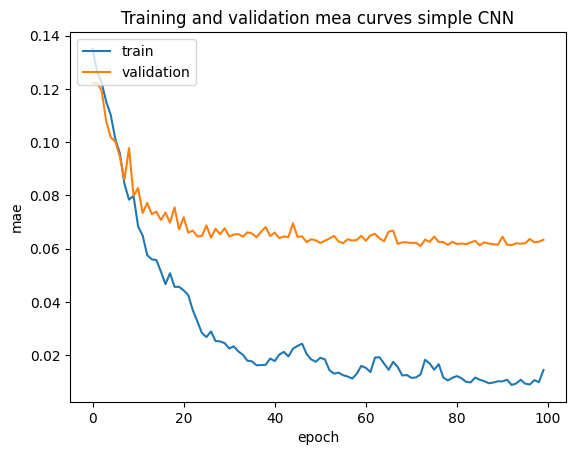

In [81]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Training and validation mea curves simple CNN')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [82]:
#test_loss, test_accuracy=model.evaluate(X_test,y_test, steps=int(100))
y_cnn=model.predict(X_test)
print(y_cnn)

3/3 [==============================] - 0s 17ms/step
[[ 0.5215642   0.82749987  0.70619345  1.008007  ]
 [ 0.28724524  0.28452355  0.76028615  0.74228513]
 [ 0.28316715  0.49229598  0.50565326  0.5858837 ]
 [ 0.5277892   0.3791953   0.70487225  0.45693436]
 [ 0.6616156   0.53655326  0.85777825  0.6664158 ]
 [ 0.4484802   0.33781195  0.6595776   0.5063941 ]
 [ 0.28724524  0.28452355  0.76028615  0.74228513]
 [ 0.6392713   0.75319767  0.5435858   0.81852984]
 [ 0.2559093   0.33797744  0.75287735  0.6168137 ]
 [ 0.8187483   0.6240599   0.97889894  0.6572519 ]
 [ 0.34282795  0.47237274  0.56259036  0.5888207 ]
 [ 0.3697036   0.6877477   0.63946843  0.7817892 ]
 [ 0.49907833  0.49387068  0.6338883   0.5500568 ]
 [ 0.30404267  0.72596097  0.4766712   0.7608814 ]
 [ 0.2885499   0.55880266  0.7532395   0.699935  ]
 [ 0.35870832  0.5370859   0.51707816  0.6360722 ]
 [ 0.63271624  0.710862    0.78251976  0.7326437 ]
 [ 0.18142846  0.2940369   0.7788546   0.73557323]
 [ 0.4480606   0.63535255  0.6

### <a name='13'></a>Testing the model prediction

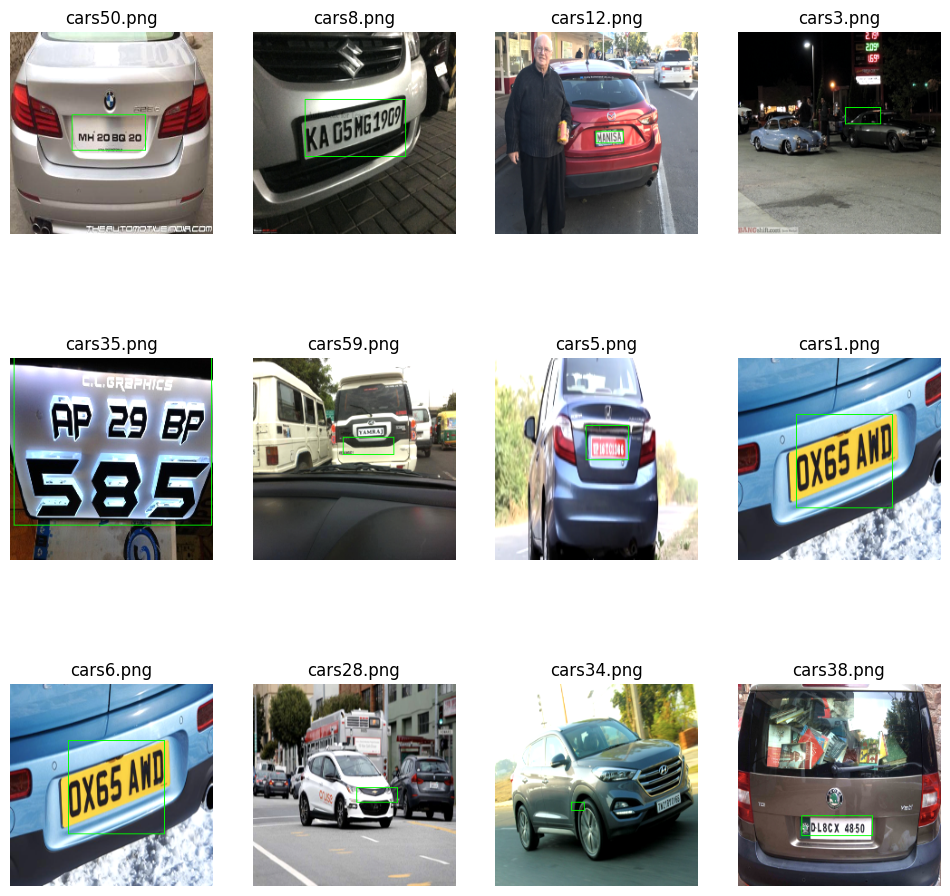

In [109]:
testing_index=[]
for i in range(12):
  testing_index.append(np.random.randint(len(X_test)-1))

plt.figure(figsize=(12, 12))
for index, i  in enumerate(testing_index):
  plt.subplot(3,4,index+1)
  plt.axis('off')
  yn=np.copy(y_cnn[i])
  yn=yn*224

  plt.title(f'cars{i}.png')

  rgb_img = cv2.cvtColor(np.copy(X_test[i]).astype('float32'), cv2.COLOR_BGR2RGB)
  image = cv2.rectangle(rgb_img,(int(yn[0]),int(yn[1])),(int(yn[2]),int(yn[3])),(0, 255, 0))
  plt.imshow(image)



### <a name='14'></a>Model1- VGG16

In [84]:
from tensorflow.python import train
X_train_1,X_test_1,y_train_1, y_test_1=train_test_split(X,y, test_size=0.2, random_state=42)
X_train_1, X_val_1, y_train_1, y_val_1= train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [85]:

model1 = Sequential()
model1.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model1.add(Flatten())
model1.add(Dropout(0.4))
model1.add(Dense(256, activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(64, activation="relu"))
model1.add(Dense(4, activation="linear"))

model1.layers[-6].trainable = False

model1.summary()

model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Definition  of the augumentation  data generator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    # Cross validation
    validation_split=0.2
)

# Model training with data augmentation
for i in range(10):
    print("Epoch", i+1)
    j = 0
    for X_batch_1, y_batch_1 in datagen.flow(X_train_1, y_train_1, batch_size=32):
        loss, mae = model1.train_on_batch(X_batch_1, y_batch_1)
        j += 1
        if j >= len(X_train_1) / 32:
            break

# Save model
model1.save("model_1.h5")

history1 = model1.fit(X_train_1, y_train_1, validation_data=(X_val_1, y_val_1), epochs=100, batch_size=10, verbose=1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                

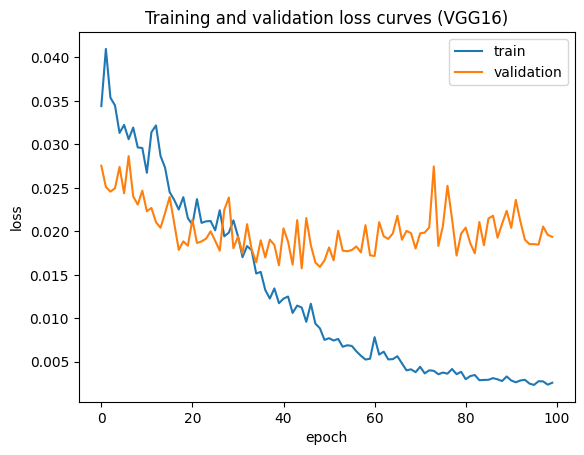

In [86]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Training and validation loss curves (VGG16)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

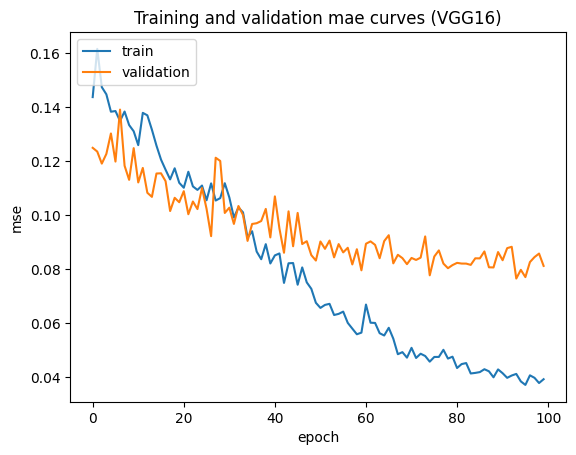

In [87]:
plt.plot(history1.history['mae'])
plt.plot(history1.history['val_mae'])
plt.title('Training and validation mae curves (VGG16)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [88]:
y_cnn1=model1.predict(X_test_1)
y_cnn1

3/3 [==============================] - 0s 144ms/step


array([[ 0.5886357 ,  0.7404004 ,  0.85485464,  0.8708151 ],
       [ 0.23432657,  0.30381215,  0.7670996 ,  0.73865163],
       [ 0.25766507,  0.5821512 ,  0.41518474,  0.70614743],
       [ 0.22103432,  0.3671406 ,  0.3803324 ,  0.47175908],
       [ 0.80803394,  0.68021065,  0.9470046 ,  0.7848394 ],
       [ 0.48908192,  0.32783294,  0.6974334 ,  0.5320851 ],
       [ 0.23432657,  0.30381215,  0.7670996 ,  0.73865163],
       [ 0.6481236 ,  0.6538061 ,  0.7715249 ,  0.742741  ],
       [ 0.19472265,  0.3061589 ,  0.7208032 ,  0.6218488 ],
       [ 0.84380674,  0.5976208 ,  0.97244245,  0.6583916 ],
       [ 0.43790668,  0.6947964 ,  0.57175165,  0.8930988 ],
       [ 0.37803718,  0.6865858 ,  0.6141824 ,  0.83869064],
       [ 0.4796575 ,  0.4544411 ,  0.6667857 ,  0.5785378 ],
       [ 0.41258666,  0.5909319 ,  0.5854168 ,  0.7653232 ],
       [ 0.2821758 ,  0.4217092 ,  0.72027755,  0.7641826 ],
       [ 0.46876884,  0.63980955,  0.64355975,  0.76035506],
       [ 0.7077164 ,  0.

### <a name='16'></a># Testing the model prediction

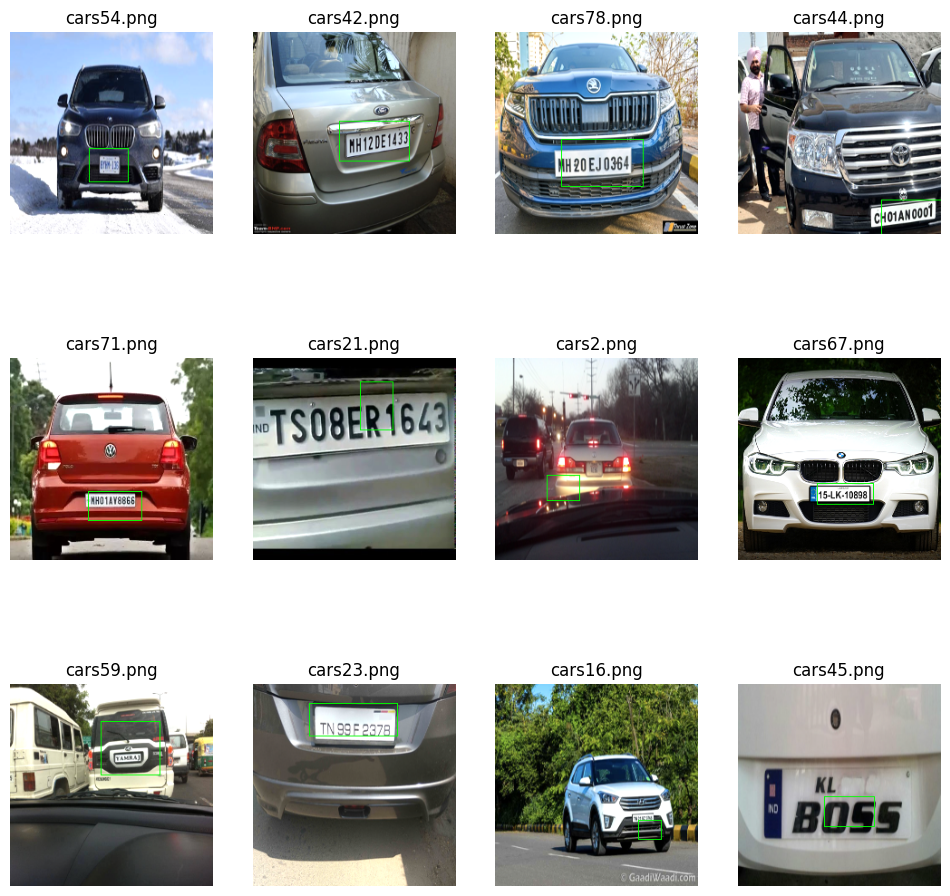

In [111]:
testing_index=[]
for i in range(12):
  testing_index.append(np.random.randint(len(X_test_1)-1))

plt.figure(figsize=(12, 12))

for index, i  in enumerate(testing_index):
  plt.subplot(3,4,index+1)
  plt.axis('off')
  yn1=np.copy(y_cnn1[i])
  yn1=yn1*224 # image size

  plt.title(f'cars{i}.png')

  rgb_img = cv2.cvtColor(np.copy(X_test_1[i]).astype('float32'), cv2.COLOR_BGR2RGB)
  image = cv2.rectangle(rgb_img,(int(yn1[0]),int(yn1[1])),(int(yn1[2]),int(yn1[3])),(0, 255, 0))
  plt.imshow(image)




# EASY OCR  PLATE RECOGNITION - Next step

In [90]:
! pip install easyocr
! install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
install: missing destination file operand after 'imutils'
Try 'install --help' for more information.


In [91]:
import cv2 as cv
import matplotlib.pyplot as plt
import imutils
import easyocr

In [92]:
image_file = "//content//drive//My Drive//Kaggle//train//Cars111.png"
img = cv2.imread(image_file,1)

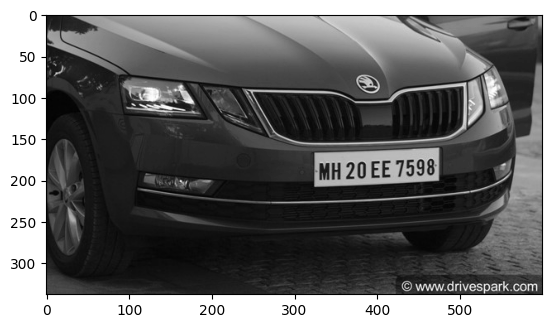

In [93]:
# read image and covert to gray scale
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)

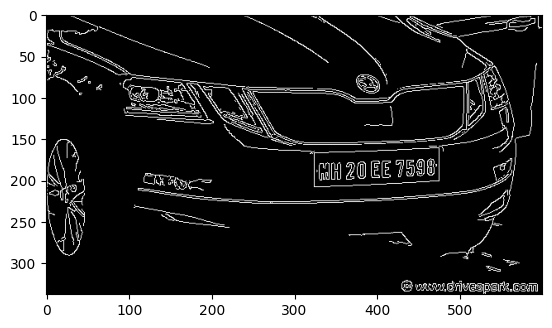

In [94]:
bfilter=cv2.bilateralFilter(gray, 11,17,17) # noise reduction
edged=cv2.Canny(bfilter, 30,200) # Edge detection
plt.imshow(cv2.cvtColor(edged,cv2.COLOR_BGR2RGB))

In [95]:
# find contours from the edged image and keep only the largest
# ones, and initialize our screen contour
keypoints=cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours=imutils.grab_contours(keypoints)
#sorts contours based on minimum area 30 and ignores the ones below that
contours=sorted(contours, key=cv2.contourArea, reverse=True)[:30]

In [96]:
location=None
for contour in contours:
  peri = cv2.arcLength(contour, True)
  approx=cv2.approxPolyDP(contour,0.018 * peri, True)
  if len(approx)==4:
   location=approx
   break
approx[1][0][1]


201

In [97]:
location

array([[[475, 162]],

       [[474, 201]],

       [[324, 207]],

       [[325, 167]]], dtype=int32)

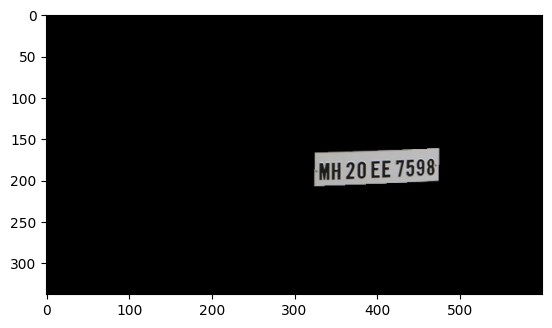

In [98]:
mask=np.zeros(gray.shape[0:2], np.uint8)
new_image=cv2.drawContours(mask,[location],0,255,-1)
new_image=cv2.bitwise_and(img,img, mask=mask)
plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))

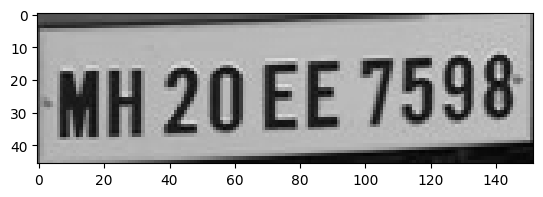

In [99]:
(x,y)=np.where(mask==255)
(x1,y1)=(np.min(x),np.min(y))
(x2,y2)=(np.max(x),np.max(y))
cropped_image=gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image,cv2.COLOR_BGR2RGB))

In [100]:
reader=easyocr.Reader(['en'])
result=reader.readtext(cropped_image)




In [101]:
text=result[0][-2]
print(f" Recognized car label:{text}")

 Recognized car label:MH 20 EE 7598


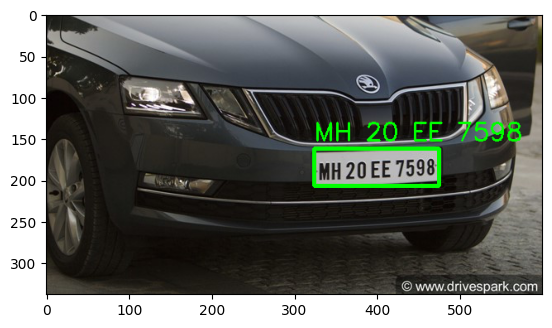

In [102]:
res=cv2.putText(img, text=text,org=(approx[2][0][0],approx[0][0][1]-10),fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,255,0), thickness=2)
res=cv2.rectangle(img,tuple(approx[0][0]), tuple(approx[2][0]),(0,255,0), 3)
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))